# Separating spirals with a multi-layer perceptron

This notebook explores how a feedforward neural network can learn to separate spiraling curves.  A linear classifier is unable to separate the curves.  But, by adding hidden layers with non-linear activations, the multi-layer perceptron is able to transorm the curves into linearly separable clusters.

In [1]:
import numpy as np
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
import matplotlib as mpl
from matplotlib import pyplot as plt
import shutil
import tempfile
import urllib.request

## Data loading and preprocessing

First we load the spiral dataset, obtained from [a clustering benchmark website](http://cs.joensuu.fi/sipu/datasets/).   The first two columns contain the 2D coordinates of the points to be clustered and the third column contains the category labels.

In [2]:
# get data from web and store to temporary file
with urllib.request.urlopen('http://cs.joensuu.fi/sipu/datasets/spiral.txt') as response:
    with tempfile.NamedTemporaryFile(delete=False) as tmp_file:
        shutil.copyfileobj(response, tmp_file)
data = np.loadtxt(tmp_file.name,delimiter='\t') # load data into numpy array
np.random.shuffle(data)  # shuffle the data so that the examples are randomly ordered
x = data[:,0:2] # extract the 2D coordinates of the points
y = data[:,2]-1 # extract the class labels and convert to zero-based indexing

We convert the integer labels to "one hot" vectors, which is the form used by Keras for categorical classification problems.

In [3]:
y_onehot = to_categorical(y,3)
print('Shape of integer labels: ',y.shape)
print('Shape of one hot labels: ',y_onehot.shape)
print('Label as integer:',y[0])
print('Label as one hot vector: ',y_onehot[0])

Shape of integer labels:  (312,)
Shape of one hot labels:  (312, 3)
Label as integer: 1.0
Label as one hot vector:  [0. 1. 0.]


We preprocess the data removing the mean so that the data is centered at the origin.  This simple preprocessing is critical when training neural networks.

In [4]:
x_zerocentered = x - np.mean(x,axis=0,keepdims=True)
print('Mean of x before centering: ',np.mean(x,axis=0))
print('Mean of x after centering: ',np.mean(x_zerocentered,axis=0))

Mean of x before centering:  [18.40817308 16.34471154]
Mean of x after centering:  [-4.04235050e-16 -3.59256784e-15]


Here we plot the points and color code them to show the different classes.

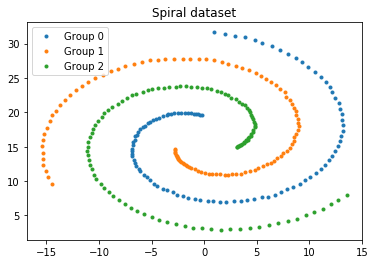

In [5]:
for i in range(3):
    sel = y_onehot[:,i]==1
    plt.plot(x_zerocentered[sel,0],x[sel,1],'.',label='Group %d'%i)
plt.title('Spiral dataset')
plt.legend()
plt.show()

## Linear classifier

Here we build a linear classifier model in Keras to try to separate the points into three classes.  Because the linear classifier can only divide the space using straight lines, it will be unable to separate the curves.

The linear classifier model learns to output a vector of logits $\mathbf{z}$ using weight matrix $W$ and bias vector $\mathbf{b}$:

$$\mathbf{z} = W\mathbf{x}+\mathbf{b}$$

$z_i$ contains the logit for class $i$.  The probability $p(c_i|x)$ of assigning a data point $\mathbf{x}$ to class $i$ is

$$p(c_i|x) = \frac{\exp(z_i)}{\sum_j \exp(z_j)}$$.

This is called the softmax function.  The corresponding loss function is $-\log p(c|x)$, which is the categorical cross entropy:

$$L(c_i|x) = -z_i+\log(\sum_j \exp(z_j))$$

In [6]:
inputs = Input(shape=(2,))  # Input layer: 2-dimensional vector
outputs = Dense(3,activation='softmax')(inputs)   # Output layer: 3-dimensional vector
model = Model(inputs=inputs,outputs=outputs)
model.compile('rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense (Dense)                (None, 3)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
None


To learn the model we apply mini-batch gradient descent using the categorical cross-entropy loss function.  We track the accuracy of the classifier during training.

By checking the accuracy of the model of the training, we can see that the linear classifier is only able to reach about 30% or 40% accuracy.

In [7]:

def train_model(model,epochs=100,validation_split=0):
  history = model.fit(x_zerocentered,y_onehot,batch_size=10,epochs=epochs,verbose=False,validation_split=validation_split)
  results = model.evaluate(x_zerocentered,y_onehot,verbose=False)
  print('Final accuracy of classifier: ',results[1]*100)
  return history

history = train_model(model,epochs=50)

Final accuracy of classifier:  32.051281974865844


Here we plot the points again and color code them with the label predicted by the linear classifier.

The decision regions used to separate the classes are apparent from the color coding.

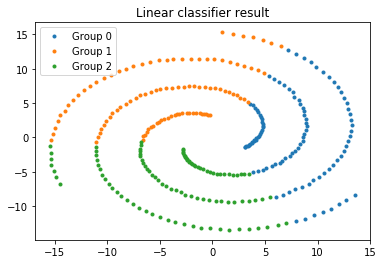

In [8]:
def plot_result(model):
  y_pred = np.argmax(model.predict(x_zerocentered),axis=-1)
  for i in range(3):
      sel = y_pred==i
      plt.plot(x_zerocentered[sel,0],x_zerocentered[sel,1],'.',label='Group %d'%i)
  plt.title('Linear classifier result')
  plt.legend()
  plt.show()
  
plot_result(model)

## Multi-layer Perceptron

Now we will build a simple feed-forward neural network called a multi-layer perceptron (MLP) to learn to better separate the spiral curves.  The MLP composes several linear classifiers together and adds non-linear activations $\sigma(\cdot)$ between them:

$$z_i = W_2 \sigma( W_1 x + b_1 ) + b_2$$

The internal, "hidden" layers of the MLP represent consecutive transformations of the input features.  By the end of the transformation sequence, the data should be transformed in such a way that a linear classifier can successfully separate the different classes.  The MLP learns how to "unwrap" the spirals, in a sense.

In this example we use two hidden layers with ReLU activation:

$$\sigma(x) = \max(0,x)$$

and we add a third layer with linear activation and two neurons.  We call this layer the "embedding" layer.  While in practice it would not make sense to use such a small bottleneck layer or linear activation, we use it here so that we can easily visualize how the network learns to transform the input space to a linearly separable output space.

Note the huge increase in parameters over the linear classifier model which had only nine parameters.  Our MLP model has about 10,000 parameters.

In [9]:
def build_mlp_model(num_hidden_layers=2,num_hidden_units=100,activation='relu'):  
  inputs = Input(shape=(2,))  # Input layer: 2-dimensional vector
  
  hidden = inputs
  for i in range(num_hidden_layers):
    hidden = Dense(num_hidden_units,activation=activation)(hidden) # hidden layers
    
  embedding = Dense(2,activation=None,use_bias=False)(hidden) # embedding layer: 2 neurons, linear activation
  
  outputs = Dense(3,activation='softmax')(embedding) # output layer: 3-dimensional vector with softmax activation
  
  mlp = Model(inputs=inputs,outputs=outputs) # MLP model for end-to-end training
  encoder = Model(inputs=inputs,outputs=embedding) # Encoder model for visualizing the embedding
  
  mlp.compile('rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
  
  return mlp, encoder

mlp, encoder = build_mlp_model(num_hidden_layers=2,num_hidden_units=100,activation='relu')
print(mlp.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 200       
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 9         
Total params: 10,609
Trainable params: 10,609
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
def train_mlp_model(mlp,epochs=100,validation_split=0):
  history = mlp.fit(x_zerocentered,y_onehot,batch_size=10,epochs=epochs,verbose=False,validation_split=validation_split)
  results = mlp.evaluate(x_zerocentered,y_onehot,verbose=False)
  print('Final accuracy of classifier: ',results[1]*100)
  return history

history = train_mlp_model(mlp,epochs=100,validation_split=0)

Final accuracy of classifier:  100.0


Here we plot the progression of the model's accuracy on the training data throughout the training process.

Our MLP model is able to perfectly separate all of the classes with 100% accuracy.


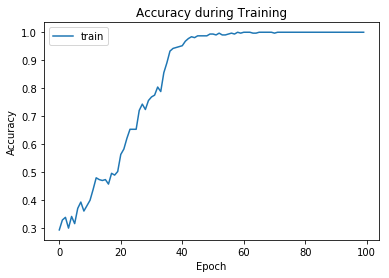

In [11]:
def plot_history(history):
  plt.plot(history.history['acc'],label='train')
  if 'val_acc' in history.history:
    plt.plot(history.history['val_acc'],label='val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.title('Accuracy during Training')
  plt.show()

plot_history(history)

Plotting the classification result shows that the MLP classifier is able to separate the curves in a way that the linear classifier could not.

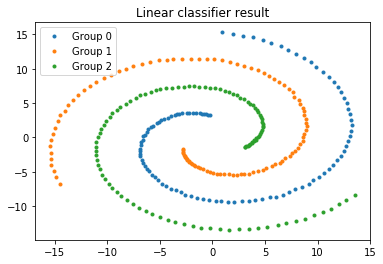

In [12]:
plot_result(mlp)

Here we plot the embedding vectors produced by the MLP model.  The spiral curves have been transformed into distinct clusters, making the final linear classifier's job easy.

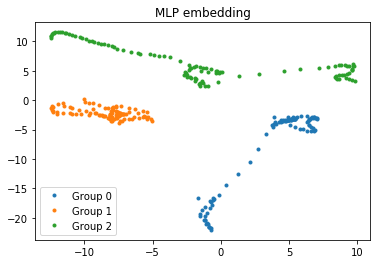

In [13]:
def plot_embedding(encoder):
  h = encoder.predict(x_zerocentered)
  for i in range(3):
      sel = y==i
      plt.plot(h[sel,0],h[sel,1],'.',label='Group %d'%i)
  plt.title('MLP embedding')
  plt.legend()
  plt.show()
  
plot_embedding(encoder)

## Exercises

* Try removing the ReLU activations in the MLP.  What happens?  Why?
* Try other activations such as sigmoid and tanh to see if they work as well as ReLU.  You might need to increase the number of epochs.
* We used two hidden layers with 100 units each for our MLP, resulting in a model with over 10,000 parameters.  Try changing the number of hidden layers and hidden units to see if there is a lower or upper limit on the model size with this dataset.
* Compare using a large number of hidden layers and a small number of hidden units (deep network) versus using a single hidden layer and a large number of hidden units (wide network).  Which is better?  Consider the number of parameters in the network and the accuracy of the results.
* Try reserving a validation split of the data using the validation_split argument to train_mlp_model().  Is our MLP model able to generalize to unseen data?

## Network without non-linear activations

To remove ReLU, we set the activation of the Dense layers to be None (i.e., linear activation).  This means that no linear activation is applied between hidden layers:

$$\mathbf{z} = \mathbf{W}_2(\mathbf{W}_1\mathbf{x}+\mathbf{b}_1)+\mathbf{b}_2$$

Without the non-linear activation, the network becomes equivalent to a linear classifer:

$$\mathbf{z} = \mathbf{W}_2\mathbf{W}_1\mathbf{x}+(\mathbf{W}_2\mathbf{b}_1+\mathbf{b}_2)$$
$$\mathbf{z} = \mathbf{W}\mathbf{x}+\mathbf{b}$$

so the result is the same as the linear classifier above.


Final accuracy of classifier:  32.37179479537866


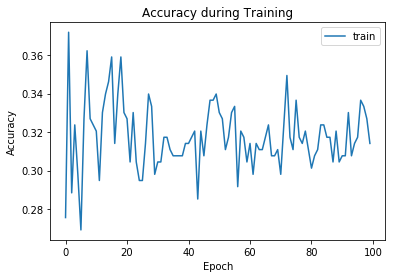

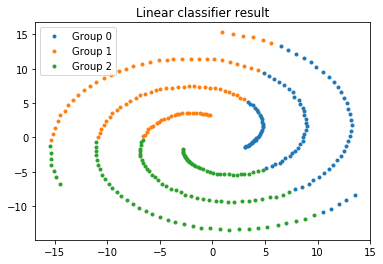

In [14]:
mlp, encoder = build_mlp_model(num_hidden_layers=2,num_hidden_units=100,activation=None)
history = train_mlp_model(mlp,epochs=100,validation_split=0)
plot_history(history)
plot_result(mlp)

## Alternate activation functions

With sigmoid activation, the network trains more slowly but was able to reach 100% accuracy in 400 epochs.

Tanh trained a bit more quickly and was able to reach 100% accuracy in 100 epochs.

Final accuracy of classifier:  100.0


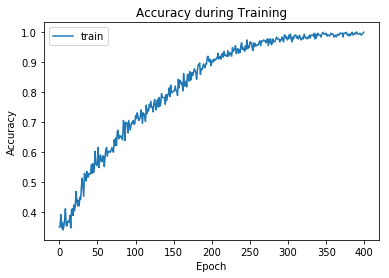

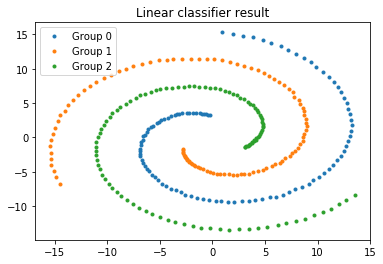

In [15]:
mlp, encoder = build_mlp_model(num_hidden_layers=2,num_hidden_units=100,activation='sigmoid')
history = train_mlp_model(mlp,epochs=400,validation_split=0)
plot_history(history)
plot_result(mlp)

Final accuracy of classifier:  100.0


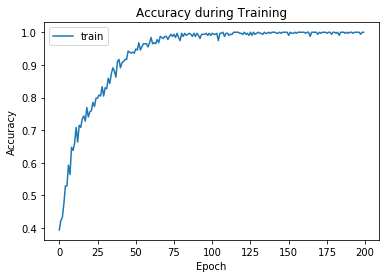

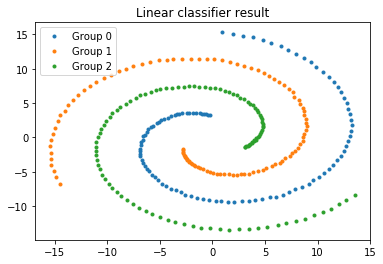

In [16]:
mlp, encoder = build_mlp_model(num_hidden_layers=2,num_hidden_units=100,activation='tanh')
history = train_mlp_model(mlp,epochs=200,validation_split=0)
plot_history(history)
plot_result(mlp)

## Model size comparison



I tried a very small network with one hidden layer and 10 hidden units.  Surprisingly, it was able to reach 100% accuracy, but required about 600 epochs to get there.

Final accuracy of classifier:  100.0


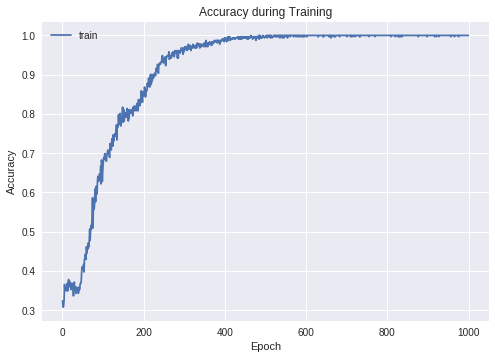

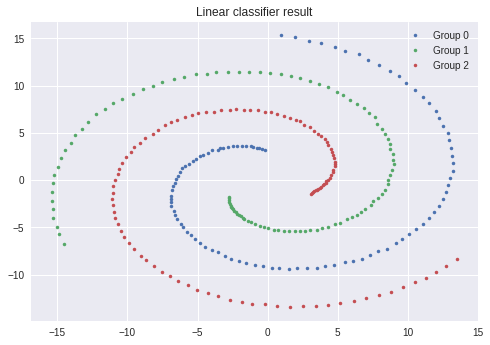

In [19]:
mlp, encoder = build_mlp_model(num_hidden_layers=1,num_hidden_units=10,activation='relu')
history = train_mlp_model(mlp,epochs=1000,validation_split=0)
plot_history(history)
plot_result(mlp)

Interestingly, the embedding still has some spiral-like shapes in it!

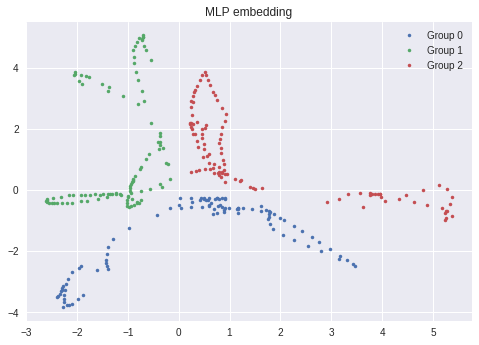

In [20]:
plot_embedding(encoder)

A deeper network (10 layers with 10 units each) does about as well -- perhaps the learning rate needs to be reduced, though.

Final accuracy of classifier:  99.35897435897436


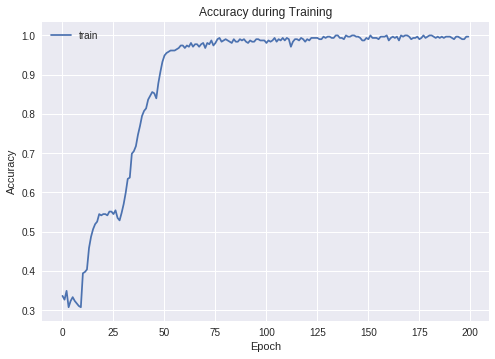

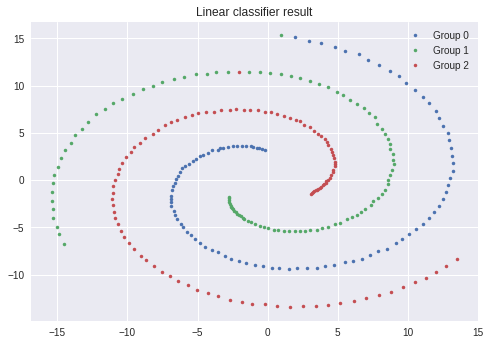

In [25]:
mlp, encoder = build_mlp_model(num_hidden_layers=10,num_hidden_units=10,activation='relu')
history = train_mlp_model(mlp,epochs=200,validation_split=0)
plot_history(history)
plot_result(mlp)

As seen above, the smaller, shallower network seems to be working well on this dataset.   There doesn't seem to be a trade-off between wide and deep networks here.

## Adding a validation split

I used my best model (1 hidden layer, 10 hidden units) but trained with a validation split of 10%.  The validation accuracy is a bit below the training accuracy.  We can conclude that this model is able to generalize, but not perfectly.

Final accuracy of classifier:  99.35897451180679


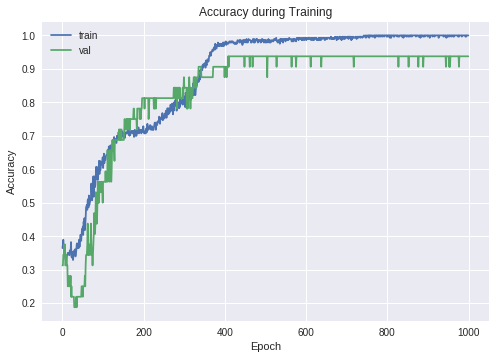

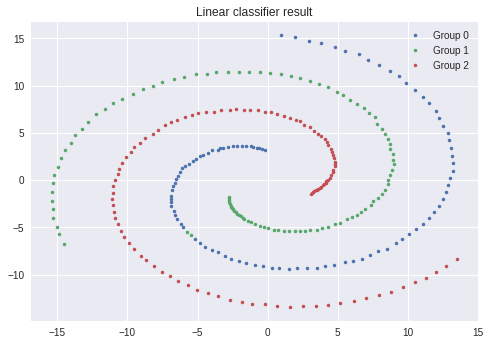

In [29]:
mlp, encoder = build_mlp_model(num_hidden_layers=1,num_hidden_units=10,activation='relu')
history = train_mlp_model(mlp,epochs=1000,validation_split=0.1)
plot_history(history)
plot_result(mlp)